In [1]:
import logging
from argparse import ArgumentParser

import torch
import torch.nn.functional as F
# import wandb
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm import trange

from experiments.data import INRDataset
from experiments.utils import (
    common_parser,
    count_parameters,
    get_device,
    set_logger,
    set_seed,
    str2bool,
)
from nn.models import DWSModelForClassification, MLPModelForClassification , DWSModel

from experiments.mnist.generate_data_splits import generate_splits
from experiments.mnist.compute_statistics import compute_stats

set_logger()

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.enabled = False

## INR Dataset

We create INR Datasets and Dataloaders, and visualize some INRs (by reconstruction the images).



In [4]:
#Loading inr data we created while mnist training
import os
current_working_directory = os.getcwd()
print(current_working_directory)
path = current_working_directory + "/notebooks/dataset/mnist_splits.json"
statistics_path = current_working_directory + "/notebooks/dataset/statistics.pth"
normalize = True
augmentation = True

batch_size = 32
num_workers = 1

/work/talisman/sgupta/DWSNets/equivariant-diffusion


/work/talisman/sgupta/DWSNets/equivariant-diffusion/experiments/data.py:315: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location="cpu")


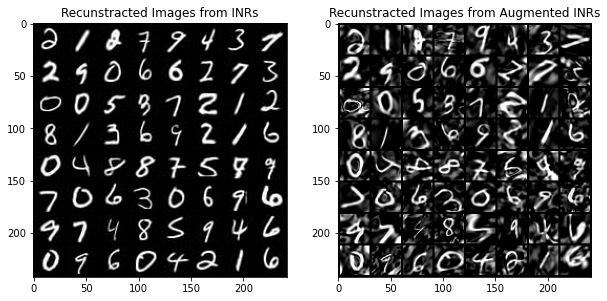

In [5]:
from torchvision.utils import save_image, make_grid
import torch

from experiments.data import INRImageDataset
from experiments.utils import set_seed
import matplotlib.pyplot as plt
dataset = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=False,
    split="train",
)

loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

dataset_aug = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=True,
    split="train",
)
loader_aug = torch.utils.data.DataLoader(dataset_aug, batch_size=64, shuffle=False)

batch = next(iter(loader))
batch_aug = next(iter(loader_aug))

fig, axs = plt.subplots(1, 2, figsize=(10,20)) 

axs[0].imshow(make_grid(batch.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[0].set_title('Recunstracted Images from INRs')

axs[1].imshow(make_grid(batch_aug.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[1].set_title('Recunstracted Images from Augmented INRs')
plt.show()

In [6]:
train_set = INRDataset(
        path=path,
        split="train",
        normalize=normalize,
        augmentation=augmentation,
        statistics_path=statistics_path,
    )

val_set = INRDataset(
    path=path,
    split="val",
    normalize=normalize,
    statistics_path=statistics_path,
)

test_set = INRDataset(
    path=path,
    split="test",
    normalize=normalize,
    statistics_path=statistics_path,
)

train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

logging.info(
    f"train size {len(train_set)}, "
    f"val size {len(val_set)}, "
    f"test size {len(test_set)}"
)

/work/talisman/sgupta/DWSNets/equivariant-diffusion/experiments/data.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.stats = torch.load(statistics_path, map_locati

In [7]:
point = train_set.__getitem__(4)
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)
print(weight_shapes,bias_shapes)
# print(point.weights,point.biases,point.label)

(torch.Size([2, 32]), torch.Size([32, 32]), torch.Size([32, 1])) (torch.Size([32]), torch.Size([32]), torch.Size([1]))


/work/talisman/sgupta/DWSNets/equivariant-diffusion/experiments/data.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=lambda 

In [8]:
new_weight_shapes = (torch.Size([2, 8]), torch.Size([8, 8]), torch.Size([8, 1]))
new_bias_shapes = (torch.Size([8]), torch.Size([8]), torch.Size([1]))

In [9]:
from typing import Tuple
import torch
import torch.nn as nn
from nn.layers import BN, DWSLayer,InvariantLayer, Dropout, ReLU
from nn.layers.base import BaseLayer,GeneralSetLayer

class DWSEncoder(BaseLayer):
    def __init__(
       self,
        weight_shapes,
        bias_shapes,
        input_features,
        hidden_dims,
        downsample_dim,
        n_hidden=2,
        reduction="max",
        bias=True,
        n_fc_layers=1,
        num_heads=4,
        set_layer="sab",
        add_layer_skip=False,
        input_dim_downsample=None,
        init_scale=1.,
        init_off_diag_scale_penalty=1.,
        bn=False,
        dropout_rate = 0.001,
        diagonal=False,
    ):
        super().__init__(
            in_features=input_features,
            out_features=hidden_dims,
            bias=bias,
            reduction=reduction,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
        )

        assert len(weight_shapes) > 2, "The implementation only supports networks with more than 2 layers."

        self.downsample_dim = downsample_dim
        self.bias = bias
        self.n_fc_layers = n_fc_layers
        self.num_heads = num_heads
        
        self.skip = self._get_mlp(
            in_features=input_features,
            out_features=input_features,
            bias=bias,
        )
        
        self.InitialLayer = DWSModel(
            weight_shapes= weight_shapes,
            bias_shapes= bias_shapes,
            input_features=input_features,
            hidden_dim=hidden_dims,
            n_hidden=n_hidden,
            reduction=reduction,
            bias=bias,
            output_features=input_features,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
            dropout_rate=dropout_rate,
            input_dim_downsample=input_dim_downsample,
            init_scale=init_scale,
            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
            bn=bn,
            add_skip=False,
            add_layer_skip=add_layer_skip,
            diagonal=diagonal,
        )   

    def downsample_input_weights(self, inputs, downsample_dim):
        """Downsample the input weights to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first weight dimension [32,2,32,1] -> [32,2,8,1]
        inputs[0] = self._downsample_weight(inputs[0], dim=2, downsample_dim = downsample_dim)
        # Downsample second weight dimension [32,32,32,1] -> [32,8,8,1]
        inputs[1] = self._downsample_weight(inputs[1], dim=1, downsample_dim = downsample_dim)
        inputs[1] = self._downsample_weight(inputs[1], dim=2, downsample_dim = downsample_dim)

        # Downsample third weight dimension [32,32,1,1] -> [32,8,1,1]
        inputs[2] = self._downsample_weight(inputs[2], dim=1, downsample_dim = downsample_dim)

        return tuple(inputs)

    def downsample_input_biases(self, inputs, downsample_dim):
        """Downsample the input biases to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first bias dimension [32,32,1] -> [32,8,1]
        inputs[0] = self._downsample_bias(inputs[0], downsample_dim= downsample_dim)

        # Downsample second bias dimension [32,32,1] -> [32,8,1]
        inputs[1] = self._downsample_bias(inputs[1], downsample_dim = downsample_dim)

        return tuple(inputs)
    
    def batchNormLayer(self,weights, biases):
        relu = nn.ReLU()
        weights = tuple(relu(nn.BatchNorm2d(w.shape[1]).to(device)(w)) for w in weights)
        biases = tuple(relu(nn.BatchNorm1d(b.shape[1]).to(device)(b.squeeze(-1)).unsqueeze(-1)) for b in biases)
        return weights, biases

    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
        """Forward pass through the encoder."""
        x = self.InitialLayer(x)
        weights = self.downsample_input_weights(x[0], 24)
        biases = self.downsample_input_biases(x[1], 24)
        weights= (weights[0] + self.skip(weights[0]), weights[1] + self.skip(weights[1]) ,weights[2] + self.skip(weights[2]))
        biases = (biases[0] + self.skip(biases[0]) , biases[1] + self.skip(biases[1]) ,biases[2] + self.skip(biases[2]))
        weights, biases = self.batchNormLayer( weights, biases)
        weights = self.downsample_input_weights(weights, 16)
        biases = self.downsample_input_biases(biases, 16)
        weights= (weights[0] + self.skip(weights[0]), weights[1] + self.skip(weights[1]) ,weights[2] + self.skip(weights[2]))
        biases = (biases[0] + self.skip(biases[0]) , biases[1] + self.skip(biases[1]) ,biases[2] + self.skip(biases[2]))
        weights, biases = self.batchNormLayer( weights, biases)
        weights = self.downsample_input_weights(weights, self.downsample_dim)
        biases = self.downsample_input_biases(biases, self.downsample_dim)
        weights= (weights[0] + self.skip(weights[0]), weights[1] + self.skip(weights[1]) ,weights[2] + self.skip(weights[2]))
        biases = (biases[0] + self.skip(biases[0]) , biases[1] + self.skip(biases[1]) ,biases[2] + self.skip(biases[2]))
        out = (weights, biases)
        return out

    def _downsample_weight(self, weight, dim,downsample_dim):
        d0 = weight.shape[dim]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features= downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = weight.permute(0, 3, 1, 2) if dim == 2 else weight.permute(0, 3, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 3, 1) if dim == 2 else wi.permute(0, 3, 2, 1)

    def _downsample_bias(self, bias, downsample_dim):
        d0 = bias.shape[1]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features=downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = bias.permute(0, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 1)

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim=None):
        super(ResidualBlock, self).__init__()
        if output_dim is None:
            output_dim = input_dim 

        self.fc1 = nn.Linear(input_dim, output_dim)
        self.fc2 = nn.Linear(output_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.fc1(x))  # First linear transformation + ReLU
        x = self.fc2(x)  # Second linear transformation
        return self.relu(x + residual)

class BiasResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.relu(x + residual)

In [11]:
import torch
import torch.nn as nn

class Decoder(nn.Module,
             ):
    def __init__(self, upsample_dim,
                weight_shapes,
                bias_shapes,
                input_features,
                hidden_dims,
                downsample_dim,
                n_hidden=2,
                reduction="max",
                set_layer="sab",
                add_layer_skip=False,
                input_dim_downsample=None,
                init_scale=1.,
                init_off_diag_scale_penalty=1.,
                bn=False,
                dropout_rate = 0.001,
                diagonal=False,
                 bias=True,
                 n_fc_layers=1,
                 num_heads=4):
        
        super(Decoder, self).__init__()
        
        self.fc_weight_1 = nn.Sequential(
            nn.Linear(32 * 2 * 1, 16 * 2 * 1),  # Assuming input size [batch, 8, 1, 1], adjust for your dimensions
            nn.ReLU(),
            nn.Linear(16 * 2 * 1, 32 * 2 * 1),
        )
        
        self.fc_weight_2 = nn.Sequential(
            nn.Linear(32 * 32 * 1, 16 * 32 * 1),
            nn.ReLU(),
            nn.Linear(16 * 32 * 1, 32 * 32 * 1),
        )
        self.fc_weight_3 = nn.Sequential(
            nn.Linear(32 * 1 * 1, 16 * 1 * 1),
            nn.ReLU(),
            nn.Linear(16 * 1 * 1, 32 * 1 * 1),
        )

        # For Bias Reconstruction
        self.fc_bias_1 = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
        )
        self.fc_bias_2 = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
        )
        self.fc_bias_3 = nn.Sequential(
            nn.Linear(1, 1),
            nn.ReLU(),
            nn.Linear(1, 1),
        )
        
        self.upsample_dim = upsample_dim
        self.bias = bias
        self.n_fc_layers = n_fc_layers
        self.num_heads = num_heads
        
        self.InitialLayer = DWSModel(
            weight_shapes= weight_shapes,
            bias_shapes= bias_shapes,
            input_features=input_features,
            hidden_dim=hidden_dims,
            n_hidden=n_hidden,
            reduction=reduction,
            bias=bias,
            output_features=input_features,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
            dropout_rate=dropout_rate,
            input_dim_downsample=input_dim_downsample,
            init_scale=init_scale,
            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
            bn=bn,
            add_skip=False,
            add_layer_skip=add_layer_skip,
            diagonal=diagonal,
        )   
        
    def upsample_input_weights(self, inputs):
        """Upsample the input weights to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first weight dimension [32,2,8,1] -> [32,2,32,1]
        inputs[0] = self._upsample_weight(inputs[0], dim=2 , index = 0)

        # Downsample second weight dimension [32,8,8,1] -> [32,32,32,1]
        inputs[1] = self._upsample_weight(inputs[1], dim=1, index = 1)
        inputs[1] = self._upsample_weight(inputs[1], dim=2, index = 1)


        # Downsample third weight dimension [32,8,1,1] -> [32,32,1,1]
        inputs[2] = self._upsample_weight(inputs[2], dim=1, index = 2)

        return tuple(inputs)

    def upsample_input_biases(self, inputs):
        """Upsample the input biases to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first bias dimension [32,8,1] -> [32,32,1]
        inputs[0] = self._upsample_bias(inputs[0], index = 0)

        # Downsample second bias dimension [32,8,1] -> [32,32,1]
        inputs[1] = self._upsample_bias(inputs[1], index = 1)

        return tuple(inputs)
    
    def _upsample_weight(self, weight, dim, index):
        d0 = weight.shape[dim]
        up_sample = GeneralSetLayer(
            in_features=d0,
            out_features=self.upsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = weight.permute(0, 3, 1, 2) if dim == 2 else weight.permute(0, 3, 2, 1)
        wi = up_sample(wi)
        wi = wi.permute(0, 2, 3, 1) if dim == 2 else wi.permute(0, 3, 2, 1)
        return wi 

    def _upsample_bias(self, bias, index):
        d0 = bias.shape[1]
        up_sample = GeneralSetLayer(
            in_features=d0,
            out_features=self.upsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        bi = bias.permute(0, 2, 1)
        bi = up_sample(bi)
        bi = bi.permute(0, 2, 1)
        return bi


    def forward(self, x):
        # Decode weight tensors
        weight_space = self.upsample_input_weights(x[0])
        bias_space = self.upsample_input_biases(x[1])

        (weight_space , bias_space) = self.InitialLayer((weight_space , bias_space))
        # Process weight input 1 (32, 2, 32, 1)
        x1 = weight_space[0].reshape(weight_space[0].size(0), -1) 
        x1 = self.fc_weight_1(x1)
        x1 = x1.reshape(weight_space[0].size())
        
        # Process weight input 2 (32, 32, 32, 1)
        x2 = weight_space[1].reshape(weight_space[1].size(0), -1) 
        x2 = self.fc_weight_2(x2)
        x2 = x2.reshape(weight_space[1].size())  # Output similar to (32, 32, 32, 1)
        
        # Process weight input 3 (32, 32, 1, 1)
        x3 = weight_space[2].reshape(weight_space[2].size(0), -1) 
        x3 = self.fc_weight_3(x3)
        x3 = x3.reshape(weight_space[2].size())  # Output similar to (32, 32, 1, 1)
        
        # Process bias input 1 (32, 32, 1)
        b1 = bias_space[0].reshape(bias_space[0].size(0), -1)  # Flatten (32, 32, 1) to (32, 32)
        b1 = self.fc_bias_1(b1)
        b1 = b1.reshape(bias_space[0].size())  # Reshape back to (32, 32, 1)
        
        # Process bias input 2 (32, 1, 1)
        b2 = bias_space[1].reshape(bias_space[1].size(0), -1)  # Flatten (32, 32, 1) to (32, 32)
        b2 = self.fc_bias_2(b2)
        b2 = b2.reshape(bias_space[1].size())  # Reshape back to (32, 1, 1)
        
        # Process bias input 3 (32, 1, 1)
        b3 = bias_space[2].reshape(bias_space[2].size(0), -1)  # Flatten (32, 1, 1) to (32, 1)
        b3 = self.fc_bias_3(b3)  # Using the same fc2 layer as bias_input2, or define another if needed
        b3 = b3.reshape(bias_space[2].size())  # Reshape back to (32, 1, 1)
        
        new_weight_space = (x1, x2, x3)
        new_bias_space = (b1, b2, b3)

        return (new_weight_space, new_bias_space)


In [12]:
# Our AutoEncoder using DWSModel
import numpy as np
class AutoEncoder(nn.Module):
    def __init__(self,
            input_features,
            weight_shapes,
            bias_shapes,
            hidden_dims,
            downsample_dim,
            n_hidden=2,
            reduction = "attn",
            input_dim_downsample=None,
            bn = False,
    ):
        super().__init__()
        self.encoder = DWSEncoder(weight_shapes=weight_shapes,
                                bias_shapes=bias_shapes,
                                input_features=input_features,
                                hidden_dims=hidden_dims,
                                downsample_dim = downsample_dim,
                                n_hidden=n_hidden,
                                reduction= reduction,
                                bn=bn).to(device)
        self.decoder = Decoder(upsample_dim= 32, weight_shapes=weight_shapes,
                                bias_shapes=bias_shapes,
                                input_features=input_features,
                                hidden_dims=hidden_dims,
                                downsample_dim = downsample_dim,
                                n_hidden=n_hidden,
                                reduction= reduction,
                                bn=bn).to(device)

        
    def forward(self,inputs):
        encoded_data = self.encoder(inputs)   
#         print(encoded_data)
        output = self.decoder(encoded_data)
        return output

Training MNIST

In [13]:
# import warnings
# warnings.filterwarnings("ignore")

# @torch.no_grad()
# def evaluate(model, loader):
#     model.eval()
#     loss = 0.0
#     correct = 0.0
#     total = 0.0
#     predicted, gt = [], []
#     for batch in loader:
#         batch = batch.to(device)
#         inputs = (batch.weights, batch.biases)
#         out = model(inputs)
#         loss += F.cross_entropy(out, batch.label, reduction="sum")
#         total += len(batch.label)
#         pred = out.argmax(1)
#         correct += pred.eq(batch.label).sum()
#         predicted.extend(pred.cpu().numpy().tolist())
#         gt.extend(batch.label.cpu().numpy().tolist())

#     model.train()
#     avg_loss = loss / total
#     avg_acc = correct / total

#     return dict(avg_loss=avg_loss, avg_acc=avg_acc, predicted=predicted, gt=gt)

# model = AutoEncoder(
#     input_features=1,
#     weight_shapes = weight_shapes, 
#     bias_shapes = bias_shapes,
#     downsample_dim = 8,
#     hidden_dims=32,
#     reduction = "max",
#     n_hidden=8,
#     bn=False,
# ).to(device)

# for name, param in model.named_parameters():
#     if param.dim() >= 2:  # Initialize weights (only for tensors with 2 or more dimensions)
#         # Initialize convolutional layer weights using Kaiming normal initialization
#         if 'conv' in name and 'weight' in name:
#             nn.init.kaiming_normal_(param)
#         # Initialize linear layer weights using Xavier uniform initialization
#         elif 'fc' in name and 'weight' in name:
#             nn.init.xavier_uniform_(param)
        
# model.encoder.load_state_dict(torch.load("Outputs/model_encoder_with_skip_epoch_4.pth"), strict=False)
        
# optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, amsgrad=True, weight_decay=5e-4)
# epochs = 5

# epoch_iter = trange(epochs)
# criterion = nn.CrossEntropyLoss()

# for epoch in epoch_iter:
#     for i, batch in enumerate(train_loader):
#         model.train()
#         optimizer.zero_grad()

#         batch = batch.to(device)
#         inputs = (batch.weights, batch.biases)
#         out = model(inputs)

#         loss = criterion(out, batch.label)
#         loss.backward()
#         optimizer.step()

#         epoch_iter.set_description(  
#             f"[{epoch} {i+1}], train loss: {loss.item():.3f}"
#         )
#     test_loss_dict = evaluate(model, test_loader)
#     test_acc = test_loss_dict['avg_acc'].item()
#     print(f"test accuracy:{test_acc:.4f}")
#     torch.save(model.encoder.state_dict(), f"Outputs/model_encoder_epoch_{epoch}.pth")

Training Autoencoder

In [14]:
class CombinedLoss(nn.Module):
    def __init__(self, mse_weight=0.5, cosine_weight=0.5):
        super().__init__()
        self.mse_weight = mse_weight
        self.cosine_weight = cosine_weight
        self.mse = nn.MSELoss()
        self.cosine = nn.CosineSimilarity(dim=1)

    def forward(self, output, target):
        weights1, biases1 = output
        weights2, biases2 = target
        weight_loss = [self.mse(w1, w2) for w1, w2 in zip(weights1, weights2)]
        weight_loss = torch.mean(torch.stack(weight_loss))
        
        bias_loss = [self.mse(b1, b2) for b1, b2 in zip(biases1, biases2)]
        bias_loss = torch.mean(torch.stack(bias_loss))
        
        mse_loss = 0.5*weight_loss + 0.5*bias_loss

        ## Compute cosine similarity for weights
        weight_loss = [1 - F.cosine_similarity(w1.reshape(1, -1), w2.reshape(1, -1), dim=1) for w1, w2 in zip(weights1, weights2)]
        weight_loss = torch.mean(torch.stack(weight_loss))
        
        # Compute cosine similarity for biases
        bias_loss = [1 - F.cosine_similarity(b1.reshape(1, -1), b2.reshape(1, -1), dim=1) for b1, b2 in zip(biases1, biases2)]
        bias_loss = torch.mean(torch.stack(bias_loss))
        
        cosine_loss =  0.5 * weight_loss + 0.5 * bias_loss

        # Combine losses
        total_loss = self.mse_weight * mse_loss + self.cosine_weight * cosine_loss

        return total_loss

In [15]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss = 0.0
    total = 0.0
    criterion =  CombinedLoss()
    for batch in loader:
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        out = model(inputs)
        loss += criterion(out, inputs)
        total += 1

    model.train()
    avg_loss = loss / total

    return avg_loss

In [16]:
def adjust_learning_rate(optimizer, epoch, initial_lr, lr_factor=0.1):
    """Reduces learning rate after 25 epochs, then after every 50 epochs."""
    if epoch == 25 or (epoch > 25 and (epoch - 25) % 50 == 0):
        for param_group in optimizer.param_groups:
            param_group['lr'] *= lr_factor
        print(f"Reduced learning rate at epoch {epoch} to {param_group['lr']}")
        return param_group['lr']
    return initial_lr

In [17]:
import logging
import torch
from tqdm import trange
        
def train_model(model):
    num_epochs = 500
    criterion = CombinedLoss()
    epoch_iter = trange(num_epochs)
    epoch_loss = -1
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=5)
    previous_epoch_loss = 1000

    for epoch in epoch_iter:
        total_loss = 0
        counter = 0
        
        for i, batch in enumerate(train_loader):
            model.train() 
            optimizer.zero_grad()

            batch = batch.to(device)
            inputs = (batch.weights, batch.biases)
            out = model(inputs)
            loss = criterion(out, inputs)
            loss.backward()
            optimizer.step() 

            total_loss += loss.item()
            counter += 1

            epoch_iter.set_description(
                f"[{epoch} {i+1}], train loss: {loss.item():.5f}, epoch loss: {epoch_loss:.5f}"
            )
            
            
        epoch_loss = total_loss / counter

        scheduler.step(epoch_loss)
            
        if epoch_loss<previous_epoch_loss:
            model_path = f"Outputs/model_upsampled_decoder_with_dws.pth"
            torch.save(model.state_dict(), model_path)
            previous_epoch_loss = epoch_loss
            
        if (epoch+1)%25 == 0:
             print(evaluate(model, test_loader))
    print("Training complete!")


In [19]:
#Model with DWS DownSample Layers
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)

model = AutoEncoder(
    input_features=1,
    weight_shapes = weight_shapes, 
    bias_shapes = bias_shapes,
    downsample_dim = 8,
    hidden_dims=32,
    reduction = "max",
    n_hidden=4,
    bn=True,
).to(device)

for name, param in model.named_parameters():
    if param.dim() >= 2:  # Initialize weights (only for tensors with 2 or more dimensions)
        # Initialize convolutional layer weights using Kaiming normal initialization
        if 'conv' in name and 'weight' in name:
            nn.init.kaiming_normal_(param)
        # Initialize linear layer weights using Xavier uniform initialization
        elif 'fc' in name and 'weight' in name:
            nn.init.xavier_uniform_(param)
        
# model.encoder.load_state_dict(torch.load("Outputs/model_encoder.pth"), strict=False)
model.load_state_dict(torch.load("Outputs/model_upsampled_decoder_with_dws.pth"))
train_model(model)
print(evaluate(model, test_loader))

<ipython-input-19-2e1d8bf2452d>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Outputs/model_upsampled_decoder_with_dws.pth"))
[0 1626],

KeyboardInterrupt: 